The object type is <class 'pandas.core.frame.DataFrame'>
        close                 datetime         SMA
199  124.6200  2023-01-03 12:49:00 EST  125.807350
200  124.6112  2023-01-03 12:50:00 EST  125.781606
201  124.6000  2023-01-03 12:51:00 EST  125.756356
202  124.6100  2023-01-03 12:52:00 EST  125.732106
203  124.5460  2023-01-03 12:53:00 EST  125.704688
..        ...                      ...         ...
294  124.5384  2023-01-03 14:24:00 EST  124.729304
295  124.4850  2023-01-03 14:25:00 EST  124.723770
296  124.5450  2023-01-03 14:26:00 EST  124.719546
297  124.5350  2023-01-03 14:27:00 EST  124.715645
298  124.5050  2023-01-03 14:28:00 EST  124.711655

[100 rows x 3 columns]


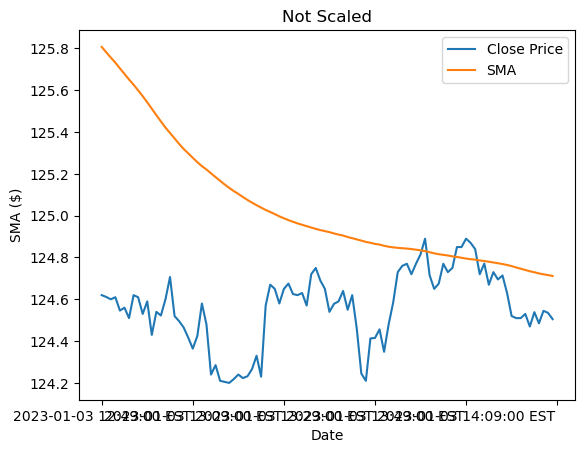

In [5]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse


def get_client():
    return RESTClient("ocunxnOqC0pnltRqT3VkOiKeCmPE49L7")


# TODO: Account for market holidays and half-days
# TODO: Determine timezone from stock/equity ticker
def within_trading_hours(
    timestamp: Union[str, int, datetime, date], timezone: str
) -> bool:
    """
    Determine whether a given instant is within trading hours for a particular exchange.

    :param timestamp: The timestamp (in milliseconds) to be checked.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: True if the timestamp is within trading hours, False otherwise.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    if dt.weekday() < 5:
        opening_time = dt.replace(hour=9, minute=30, second=0, microsecond=0)
        closing_time = dt.replace(hour=16, minute=0, second=0, microsecond=0)
        return opening_time <= dt <= closing_time
    else:
        return False


# TODO: Determine timezone from stock/equity ticker
def parse_timestamp(timestamp: Union[str, int, datetime, date], timezone: str) -> str:
    """
    Parse a timestamp to a readable format for easy comparisons.

    :param timestamp: The timestamp (in milliseconds) to be formatted.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: Date-time representation in the following format: %Y-%m-%d %H:%M:%S %Z.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    return dt.strftime("%Y-%m-%d %H:%M:%S %Z")


def agg_to_dict(agg: Agg) -> dict[str, Union[None, float, int, bool]]:
    """
    Convert an aggregate object to a dictionary, and add any extra data that may be useful.

    :param agg: The aggregate object to parse.
    :return: Dictionary with keys corresponding to attributes of the object.
    """
    return {
        "open": agg.open,
        "high": agg.high,
        "low": agg.low,
        "close": agg.close,
        "volume": agg.volume,
        "vwap": agg.vwap,
        "timestamp": agg.timestamp,
        "datetime": parse_timestamp(agg.timestamp, "America/New_York"),
        "transactions": agg.transactions,
        "otc": agg.otc,
    }


def list_aggs(
    client: RESTClient,
    ticker: str,
    multiplier: int,
    timespan: str,
    # "from" is a keyword in python https://www.w3schools.com/python/python_ref_keywords.asp
    from_: Union[str, int, datetime, date],
    to: Union[str, int, datetime, date],
    include_extended_hours: bool = False,
    adjusted: Optional[bool] = None,
    sort: Optional[Union[str, Sort]] = None,
    limit: Optional[int] = None,
    params: Optional[Dict[str, Any]] = None,
    raw: bool = False,
    options: Optional[RequestOptionBuilder] = None,
) -> pd.DataFrame:
    """
    List aggregate bars for a ticker over a given date range in custom time window sizes.

    :param client: The RESTClient object to perform the request with.
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param include_extended_hours: True if pre-market and after-hours trading data are to be included, False otherwise.
    :param adjusted: Whether or not the results are adjusted for splits. By default, results are adjusted. Set this to false to get results that are NOT adjusted for splits.
    :param sort: Sort the results by timestamp. asc will return results in ascending order (oldest at the top), desc will return results in descending order (newest at the top).The end of the aggregate time window.
    :param limit: Limits the number of base aggregates queried to create the aggregate results. Max 50000 and Default 5000. Read more about how limit is used to calculate aggregate results in Polygon's on Aggregate Data API Improvements.
    :param params: Any additional query params.
    :param raw: Return raw object instead of results object.
    :return: Pandas DataFrame representation of aggregate objects.
    """
    aggs = []
    for a in client.list_aggs(
        ticker,
        multiplier,
        timespan,
        from_,
        to,
        adjusted=adjusted,
        sort=sort,
        limit=limit,
        params=params,
        raw=raw,
        options=options,
    ):
        if include_extended_hours or within_trading_hours(
            a.timestamp, "America/New_York"
        ):
            aggs.append(agg_to_dict(a))
    return pd.DataFrame(aggs)


# Set the display option to show all columns
pd.set_option("display.width", None)  # Allow display of wide DataFrames

data = list_aggs(
    get_client(), "AAPL", 1, "minute", "2023-01-01", "2023-11-14", limit=50000
)

df = pd.DataFrame()
df["close"] = data["close"]
df["datetime"] = data["datetime"]

print(f"The object type is {type(df)}")
# data = pd.DataFrame([0,1,2,3,4,5,6,7,6,5,4,3,9,10,3,3,3,3,4,9], columns=["Test"])
# data["SMA"] = data.rolling(3).mean()
# data.plot()

# pd.set_option('display.max_rows',None)
df["SMA"] = df["close"].rolling(window=200).mean()

df = df.dropna(axis=0)
df = df.iloc[:100]
print(df)

import matplotlib.pyplot as plt

ax = df.plot(x="datetime", y=["close", "SMA"])
ax.set_title("Not Scaled")
ax.set_ylabel("SMA ($)")
ax.set_xlabel("Date")
ax.legend(["Close Price", "SMA"])

# Show the plot
plt.show()


                            close         SMA
datetime                                     
2023-01-03 12:49:00 EST  124.6200  125.807350
2023-01-03 12:50:00 EST  124.6112  125.781606
2023-01-03 12:51:00 EST  124.6000  125.756356
2023-01-03 12:52:00 EST  124.6100  125.732106
2023-01-03 12:53:00 EST  124.5460  125.704688
...                           ...         ...
2023-01-03 14:24:00 EST  124.5384  124.729304
2023-01-03 14:25:00 EST  124.4850  124.723770
2023-01-03 14:26:00 EST  124.5450  124.719546
2023-01-03 14:27:00 EST  124.5350  124.715645
2023-01-03 14:28:00 EST  124.5050  124.711655

[100 rows x 2 columns]


Text(0.5, 0, 'Date')

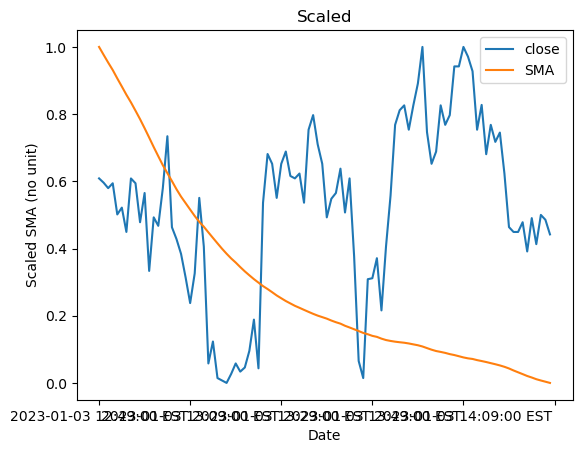

In [6]:
# Assuming df is your DataFrame with columns 'close', 'datetime', and 'SMA'
df.set_index('datetime', inplace=True)

print(df)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
ax = scaled_df.plot()
ax.set_title("Scaled")
ax.set_ylabel("Scaled SMA (no unit)")
ax.set_xlabel("Date")

In [7]:
min_values = scaler.data_min_
max_values = scaler.data_max_

print(f"Min values used in scaling | Columns: {df.columns.values} | Values: {min_values}")
print(f"Max values used in scaling | Columns: {df.columns.values} | Values: {max_values}")

Min values used in scaling | Columns: ['close' 'SMA'] | Values: [124.2       124.7116555]
Max values used in scaling | Columns: ['close' 'SMA'] | Values: [124.89    125.80735]


ML and DL